# Bivarate CDF analysis

### Objectives: 
- To test that interpolators can work to provide cumulative probability density values for the given set of correlation and z1, z2 values. 
- To test that it does not have large discrepancy between different interpolators.


In [61]:
import os
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import multivariate_normal
import joblib
import matplotlib.pyplot as plt

rho_test = np.random.uniform(-1, 0, 1000)
z1_test = np.random.uniform(-3, 3, 1000)
z2_test = np.random.uniform(-3, 3, 1000)
test_data = np.vstack((rho_test, z1_test, z2_test)).T

# Method 1: Use interpolators to calculate CDF values

In [62]:

rho, z1, z2, cdf = joblib.load(os.getcwd() + "/../GMRF/interpolator_large.joblib")
interpolators = [RegularGridInterpolator((z1, z2), cdf[i, :, :], bounds_error=False, fill_value=None) for i in range(rho.size)]

def query_cdf1(r, z1_temp, z2_temp) -> np.ndarray:
    # s1, Find the index of the closest rho layer
    i = np.abs(rho - r).argmin()
    # s2, Use the interpolator for this layer to interpolate the value
    return interpolators[i]([[z1_temp, z2_temp]])[0]

# Method 2: Use scipy module to calculate cdf 

In [63]:
def query_cdf2(r, z1_temp, z2_temp) -> float:
    cov = np.array([[1, r], [r, 1]])
    rv = multivariate_normal(np.array([0, 0]), cov)
    return rv.cdf([z1_temp, z2_temp])



In [64]:
%timeit query_cdf1(0, 0, 0)


42.9 µs ± 169 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [65]:
%timeit query_cdf2(0, 0, 0)

145 µs ± 2.08 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


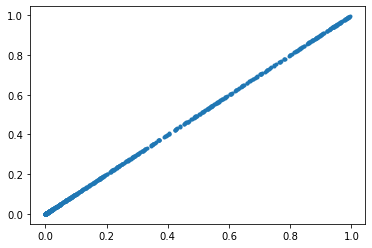

In [66]:
res1 = np.array([query_cdf1(r, zz1, zz2) for r, zz1, zz2 in test_data])
res2 = np.array([query_cdf2(r, zz1, zz2) for r, zz1, zz2 in test_data])

plt.plot(res1, res2, '.')

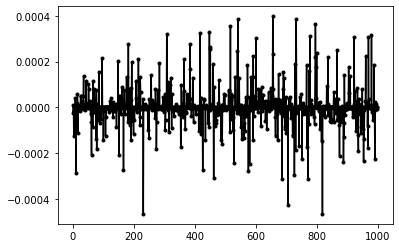

In [67]:
plt.plot(res1 - res2, 'k.-')

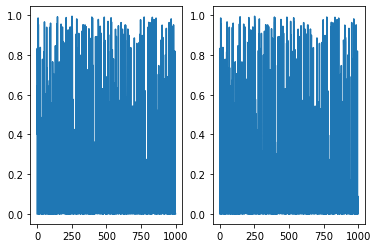

In [68]:
plt.subplot(121)
plt.plot(res1)
plt.subplot(122)
plt.plot(res2)

In [69]:
np.sum(np.abs(res1 - res2))

0.037232338518758304

# Check the difference between two interpolators

In [76]:
rho_large, z1_large, z2_large, cdf_large = joblib.load(os.getcwd() + "/../GMRF/interpolator_large.joblib")
interpolators_large = [RegularGridInterpolator((z1_large, z2_large), cdf_large[i, :, :], bounds_error=False, fill_value=None) for i in range(rho_large.size)]

rho_medium, z1_medium, z2_medium, cdf_medium = joblib.load(os.getcwd() + "/../GMRF/interpolator_medium.joblib")
interpolators_medium = [RegularGridInterpolator((z1_medium, z2_medium), cdf_medium[i, :, :], bounds_error=False, fill_value=None) for i in range(rho_medium.size)]

def query_cdf(interpolators, rho, r, zz1, zz2) -> np.ndarray:
    i = np.abs(rho - r).argmin()
    return interpolators[i]([[zz1, zz2]])[0]



In [77]:
%timeit query_cdf(interpolators_large, rho_large, 0, 0, 0)

42.8 µs ± 370 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [78]:
%timeit query_cdf(interpolators_medium, rho_medium, 0, 0, 0)

42.1 µs ± 141 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [79]:
res_large = np.array([query_cdf(interpolators_large, rho_large, r, zz1, zz2) for r, zz1, zz2 in test_data])
res_medium = np.array([query_cdf(interpolators_medium, rho_medium, r, zz1, zz2) for r, zz1, zz2 in test_data])


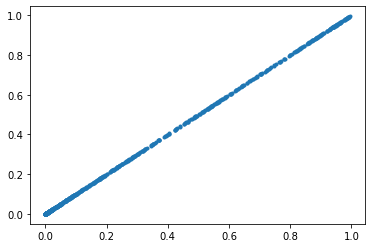

In [80]:
plt.plot(res_large, res_medium, '.')


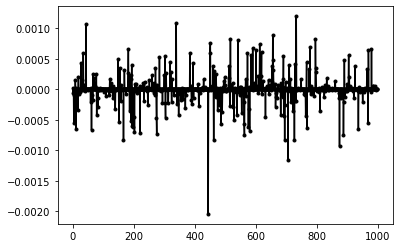

In [81]:
plt.plot(res_large - res_medium, 'k.-')

In [82]:
np.sum(np.abs(res_large - res_medium))

0.07791591479950302